##Import packages & load data

In [1]:
import pandas as pd
import numpy as np
from numpy import where

!pip install autoimpute
from autoimpute.imputations import SingleImputer

import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Lasso, SGDRegressor
import matplotlib.pyplot as plt
#from matplotlib.pyplot import pyplot

from autoimpute.imputations import SingleImputer


# Hyperparameter Tuning Packages
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, TimeSeriesSplit

from xgboost import plot_importance
!pip install shap
import shap

     |████████████████████████████████| 102kB 4.0MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 358kB 4.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491615 sha256=cd899022677a20f38110494796235c2484119b67bb108ea053f76cf76d90c5de
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
# Read the excel dataset
df = pd.read_excel('/content/drive/MyDrive/MMAI/Finance/Alfred_Dataset.xlsx')

In [81]:
# check sample
print(df.shape)
df.head(3)

(180, 37)


,Date,Target_GreaterToronto_Single_Family_HPI,1Yr_MetroOntario_CPI_All,1M_MetroOntario_CPI_all,1Yr_MetroOntario_CPI_Shelter,1M_MetroOntario_CPI_Shelter,Month,1Yr_Lag,1M_Lag,1Yr_GreaterVancounver_Single_Family_HPI,1M_GreaterVancounver_Single_Family_HPI,1Yr_Calgary_Single_Family_HPI,1M_Calgary_Single_Family_HPI,1Yr_Montreal_Single_Family_HPI,1M_Montreal_Single_Family_HPI,1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RetailSales_Toronto,1M_RetailSales_Toronto,1M_Avg_Temperature,1Yr_Avg_Temp,1M_Snow_onGround,1Yr_Snow_onGround,1Yr_Toronto_Median_Annual_Income_Couple_Families,1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families,1M_Toronto_ConstructionCompletionsUnits,1Yr_Toronto_ConstructionCompletionsUnits,1M_Toronto_ConstructionStartsUnits,1Yr_Toronto_ConstructionStartsUnits,1M_Toronto_UnempRate_15_54_yrs,1Yr_BankRate_Canada,1M_BankRate_Canada,1M_Population,1Y_S&P500_Close,1M_S&P500_Close,1Y_Bachelors_Degree_Ontario_NewRegEducation,1Y_Bachelors_Degree_Ontario_NewRegAll
0,2006-01-01,106.4,105.1,107.6,107.4,110.2,1,100.0,105.7,100.0,110.4,100.0,114.7,100.0,103.8,14281,119542,4437136,4486253,-3.446452,-6.829677,1.348387,1.070968,69900.0,31600.0,3296,3173,3401,1681,NaN,2.75,3.50,5035000.000,1181.27,1248.29,11928,333234
1,2006-02-01,107.4,105.8,108.2,107.9,111.7,2,101.3,106.4,100.5,112.6,101.1,118.9,100.9,104.7,14336,125963,4479503,4528948,0.200000,-3.995000,0.251613,1.192857,69900.0,31600.0,4427,2761,2660,2296,NaN,2.75,3.75,5042500.000,1203.60,1280.08,11928,333234
2,2006-03-01,108.7,106.4,107.9,108.2,112.0,3,102.4,107.4,101.1,114.8,102.6,125.7,101.9,106.4,14601,124172,4376561,4556689,-3.567500,-1.621290,0.771429,0.825806,69900.0,31600.0,2882,5443,1539,2941,NaN,2.75,3.75,5050011.172,1180.59,1280.66,11928,333234


In [82]:
# New column for date year
df['Year'] = df['Date'].dt.year
# drop a silly feature
df = df.drop(columns=['1Y_Bachelors_Degree_Ontario_NewRegEducation',
                      '1Yr_Calgary_Single_Family_HPI',
                      '1M_Calgary_Single_Family_HPI',
                      '1Yr_Toronto_Median_Annual_Income_Couple_Families', 
                      '1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families',
                      '1M_Lag',
                      '1Yr_Lag'
                      ])

In [89]:
#remove bubble 
df = df[df['Year']!=2017]
df = df[df['Year']!=2016]

#fix construction
def val_fix(x):
  if x >= 5000:
    y = 5000
  else:
    y = x
  return y
df['1M_Toronto_ConstructionCompletionsUnits'] = df['1M_Toronto_ConstructionCompletionsUnits'].apply(val_fix)
df['1Yr_Toronto_ConstructionCompletionsUnits'] = df['1Yr_Toronto_ConstructionCompletionsUnits'].apply(val_fix)
df['1M_Toronto_ConstructionStartsUnits'] = df['1M_Toronto_ConstructionStartsUnits'].apply(val_fix)
df['1Yr_Toronto_ConstructionStartsUnits'] = df['1Yr_Toronto_ConstructionStartsUnits'].apply(val_fix)
#visualize
df.columns

Index(['Date', 'Target_GreaterToronto_Single_Family_HPI',
       '1Yr_MetroOntario_CPI_All', '1M_MetroOntario_CPI_all',
       '1Yr_MetroOntario_CPI_Shelter', '1M_MetroOntario_CPI_Shelter', 'Month',
       '1Yr_GreaterVancounver_Single_Family_HPI',
       '1M_GreaterVancounver_Single_Family_HPI',
       '1Yr_Montreal_Single_Family_HPI', '1M_Montreal_Single_Family_HPI',
       '1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RetailSales_Toronto', '1M_RetailSales_Toronto',
       '1M_Avg_Temperature', '1Yr_Avg_Temp', '1M_Snow_onGround',
       '1Yr_Snow_onGround', '1M_Toronto_ConstructionCompletionsUnits',
       '1Yr_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_ConstructionStartsUnits',
       '1Yr_Toronto_ConstructionStartsUnits', '1M_Toronto_UnempRate_15_54_yrs',
       '1Yr_BankRate_Canada', '1M_BankRate_Canada', '1M_Population',
       '1Y_S&P500_Close', '1M_S&P500_Close',
       '1Y_Bach

#**Modeling**

#Functions

In [90]:
def clean_data(df):
   
    clean_X = df.drop(['Target_GreaterToronto_Single_Family_HPI'], axis=1)
    clean_Y = df['Target_GreaterToronto_Single_Family_HPI']
    
    return clean_X, clean_Y

def split_data(clean_X, clean_Y, train_size):
    row_num = int(clean_X.shape[0]*train_size)
    
    X_train = clean_X[:row_num].drop(['Date'], axis=1)
    Y_train = clean_Y[:row_num]
    
    X_test  = clean_X[row_num:].drop(['Date'], axis=1)
    Y_test  = clean_Y[row_num:]

    X_test_date  = clean_X[row_num:][['Date']]

    imputer = SingleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test, X_test_date

def adj_r2(X, y, y_pred):
        r2 = r2_score(y,y_pred)
        adj_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
        return r2, adj_r2

def predict_test_values(model, X_test, y_test, X_test_date, X_train, y_train):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
    print (f'RMSE of Test Data: {y_test_pred_rmse}')
    
    r2_train, adj_r2_train = adj_r2(X_train, y_train,y_train_pred)
    r2_test, adj_r2_test = adj_r2(X_test, y_test, y_test_pred)
    
    print (f'Adjusted R2 of Train Data: {adj_r2_train}')
    print (f'R2 of Test Data: {r2_test}')
    
    #Populate dataframe for plotting
    df_test_actual = pd.DataFrame(y_test).rename({'TARGET':'y_test_actual'},axis=1).reset_index(drop=True)
    df_test_pred = pd.DataFrame(y_test_pred,columns=['y_test_pred']).reset_index(drop=True)
    df_test = pd.concat([X_test_date.reset_index(drop=True),df_test_actual,df_test_pred],axis=1)
    
    #Group results
    df_test_results = df_test.groupby(['Date']).sum()
    
    return df_test_results

def plot_test_results (df_test_results, model_num):
    
    model_names = {
    1: 'XGBoost',
    2: 'Bayesian',
    3: 'ARD Regression',
    4: 'Linear Regression',   
    5: 'Lasso',
    6: 'SGD'
    }
    title = model_names[model_num] + ' Actual vs. Model Results'
    
    plt.plot(df_test_results.index, df_test_results)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(['Actual GreaterToronto_Single_Family_HPI','Predicted GreaterToronto_Single_Family_HPI']) 
    plt.grid(False)
    return plt.show()

def residual_plot(model,X, Y, hist=False,qqplot=True):
    """
    Plot *residual* to understand Homoscedasticity and heteroskedasticity
    Plot *q-q* plot for normality testing
    """
    visualizer = ResidualsPlot(model,hist=hist, qqplot=qqplot)
    visualizer.fit(X, Y) 
    return visualizer.show()

def feat_selection_step_1(model_num, X_train, y_train, X_test, y_test, top):
    """
    First stage of feature selection. Sort all faetures by predicitve power,
    by testing performance of features individually on predicting the target
    """
    rmse_score = []
    for i in range(0,len(X_train.columns)):
        X_train_samp = X_train.iloc[:, [i]]
        X_test_samp = X_test.iloc[:, [i]]
        model = models[model_num].fit(X_train_samp,y_train)
        y_test_pred = model.predict(X_test_samp)
        y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
        rmse_score.append(y_test_pred_rmse)
        
    feature_rank = pd.DataFrame(list(zip(X_train.columns,rmse_score)), columns=['col_name','rmse_score'])
    feature_rank = feature_rank.sort_values('rmse_score')
    
    feature_rank = feature_rank.head(top)
    
    pd.set_option('display.max_rows', top)
    display(feature_rank)
    pd.set_option('display.max_rows', 20)
    
    
    X_train = X_train[list(feature_rank.col_name)]
    X_test  = X_test[list(feature_rank.col_name)]
    
    return feature_rank, X_train, X_test

def feat_selection_step_2(train_data, test_data, threshold):
    """
    Second stage of feature selection, using the top 50 features from stage 1, find the 
    single highest correlated feature to each of the 50 features using pearsons r.
    
    Remove cols higher then threshold.
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = train_data.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in train_data.columns:
                    #if colname not in ['WEEK_START_DATE_MONTH','WEEK_END_DATE_MONTH','WEEK_START_DATE_WEEK','WEEK_END_DATE_WEEK']:
                    if colname not in ['Year']:
                        print('Dropped:', colname)
                        del train_data[colname] # deleting the column from the dataset
                        del test_data[colname]
        
    
    return train_data, test_data


def tuner(params, folds, model, X_train, y_train):
    """
        Do a k fold hyperparamter tune using random search
    """
    
    kf = TimeSeriesSplit(n_splits=folds)
    
    random_search = RandomizedSearchCV(model, param_distributions=params, 
                                    n_iter=len(params), scoring='neg_root_mean_squared_error', n_jobs=4,
                                       cv=kf.split(X_train,y_train), verbose=3, random_state=1001)
    random_search.fit(X_train, y_train)
    
    print('\nBest hyperparameters: ', random_search.best_params_, "\nBest Score: ", random_search.best_score_)

    return random_search.best_params_, random_search.best_estimator_

In [75]:
models = {
    1: xgb.XGBRegressor(n_estimators=100, random_state=1),
    2: BayesianRidge(normalize=True, n_iter=1000),
    3: ARDRegression(),
    4: LinearRegression(),   
    5: Lasso(),
    6: SGDRegressor()

}

##Remove bubble and clean construction outliers

#Select a Model to Run

In [91]:
train_size = 0.85 #adjustable

clean_X, clean_Y = clean_data(df)
X_train, X_test, y_train, y_test, X_test_date = split_data(clean_X, clean_Y, train_size = train_size)

In [120]:
model_num = 2

##Model Building

In [121]:
# Base model shows overfitting, negative r2 on test
from sklearn.metrics import r2_score
model = models[model_num].fit(X_train,y_train)
y_pred_t = model.predict (X_train)
y_pred_test = model.predict (X_test)
print("r2 score on train: ",r2_score(y_train,y_pred_t))
print("r2 score on test: ",r2_score(y_test,y_pred_test))
print(f'RMSE on test: {mean_squared_error(y_test,y_pred_test,squared=False)}')

r2 score on train:  0.99950064710358
r2 score on test:  0.43235990012744985
RMSE on test: 12.018406057095097


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ResidualsPlot(alpha=0.75,
              ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f486b2b56d0>,
              hist=True, line_color=None, model=None, test_color=None,
              train_color=None)

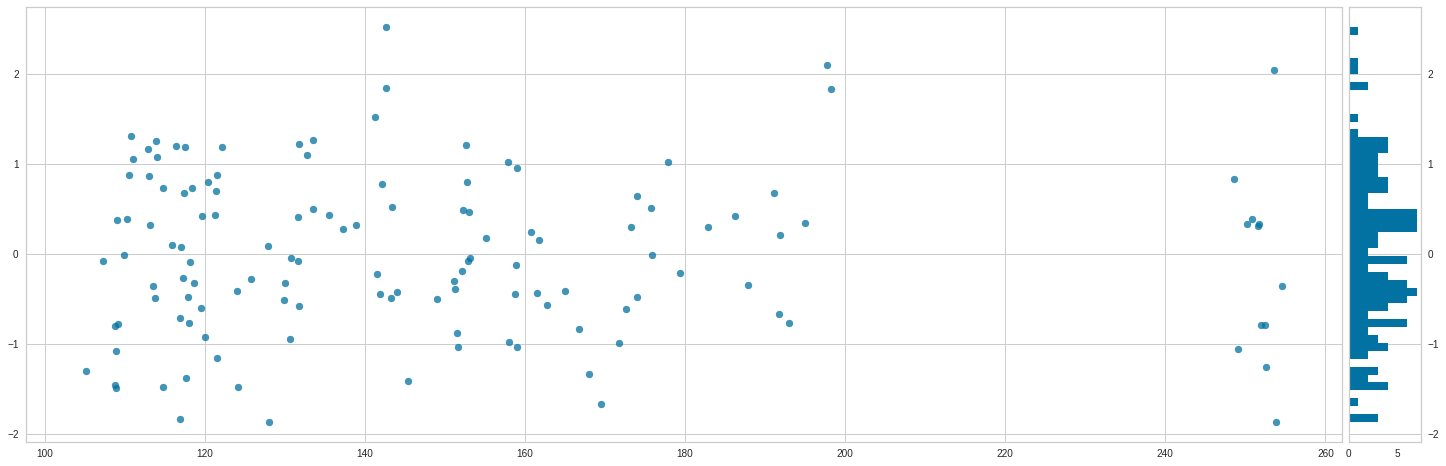

In [122]:
visualizer = ResidualsPlot(model,hist=True, qqplot=True)
visualizer.fit(X_train, y_train) 

In [123]:
X_train_cpy = X_train.copy()
X_train_cpy['prediction'] = model.predict(X_train_cpy)
X_train_cpy[X_train_cpy['prediction']>230]

,1Yr_MetroOntario_CPI_All,1M_MetroOntario_CPI_all,1Yr_MetroOntario_CPI_Shelter,1M_MetroOntario_CPI_Shelter,Month,1Yr_GreaterVancounver_Single_Family_HPI,1M_GreaterVancounver_Single_Family_HPI,1Yr_Montreal_Single_Family_HPI,1M_Montreal_Single_Family_HPI,1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RetailSales_Toronto,1M_RetailSales_Toronto,1M_Avg_Temperature,1Yr_Avg_Temp,1M_Snow_onGround,1Yr_Snow_onGround,1M_Toronto_ConstructionCompletionsUnits,1Yr_Toronto_ConstructionCompletionsUnits,1M_Toronto_ConstructionStartsUnits,1Yr_Toronto_ConstructionStartsUnits,1M_Toronto_UnempRate_15_54_yrs,1Yr_BankRate_Canada,1M_BankRate_Canada,1M_Population,1Y_S&P500_Close,1M_S&P500_Close,1Y_Bachelors_Degree_Ontario_NewRegAll,Year,prediction
144,130.8,132.0,140.2,141.1,1,268.7,292.1,163.5,169.6,19966,148254,7291637,7546279,-5.153548,-1.641613,1.261290,0.329032,2911,4419,2240,4010,4.7,0.75,1.25,6010000.000,2278.87,2673.61,452106,2018,248.532227
145,131.2,133.2,140.2,141.7,2,269.8,292.0,163.4,171.2,19891,154403,7357149,7592247,-5.616129,-0.225714,0.690323,0.742857,3346,4022,3148,2541,4.5,0.75,1.50,6016000.000,2363.64,2823.81,452106,2018,249.043402
146,131.4,134.0,140.5,141.9,3,273.8,292.5,165.7,174.1,20167,154311,7489931,7548276,-1.816071,-0.517097,1.028571,0.226667,3721,3200,5000,3844,4.7,0.75,1.50,6022005.990,2362.72,2713.83,452106,2018,252.015727
147,132.0,134.6,140.7,141.9,4,279.9,294.0,166.1,174.3,20388,155120,7668200,7697616,0.133548,9.390333,0.283871,0.066667,2551,3177,2877,3267,4.9,0.75,1.50,6028017.976,2384.20,2640.87,452106,2018,252.542608
148,131.9,134.8,140.3,141.9,5,287.3,293.5,166.8,175.6,20594,157757,7569463,7467193,3.415000,12.554839,0.346667,0.000000,3107,2201,2158,1947,5.2,0.75,1.50,6034035.964,2411.80,2648.05,452106,2018,253.835634
149,132.1,134.9,140.6,142.1,6,290.8,293.4,166.4,175.3,20678,161354,7454139,7600380,16.942581,19.359000,0.000000,0.000000,4474,2627,2075,3167,5.6,0.75,1.50,6040059.960,2423.41,2705.27,452106,2018,254.539594
150,131.9,135.3,139.8,142.4,7,294.0,291.3,166.6,175.2,20746,153359,7463299,7915755,19.497667,21.734516,0.000000,0.000000,2637,2226,4716,3792,5.6,1.00,1.50,6046089.970,2470.30,2718.37,452106,2018,252.515529
151,131.8,136.0,140.0,142.6,8,294.2,288.4,168.5,177.4,20623,162876,7713604,7761010,23.378387,20.023548,0.000000,0.000000,2762,3522,3363,4612,5.6,1.00,1.75,6052126.000,2471.65,2816.29,452106,2018,253.545554
152,132.3,135.9,140.1,142.9,9,294.5,284.2,168.2,178.1,20616,169761,7497993,7885103,23.172903,18.720667,0.000000,0.000000,1997,3612,2494,2980,5.9,1.25,1.75,6058168.056,2519.36,2901.52,452106,2018,251.607739
153,132.3,135.2,140.5,143.2,10,293.2,280.6,169.7,178.4,20648,163377,7625864,7849420,18.987333,13.273548,0.000000,0.000000,3464,2988,3570,2438,5.9,1.25,1.75,6064216.144,2575.26,2913.98,452106,2018,251.732702


RMSE of Test Data: 12.018406057095097
Adjusted R2 of Train Data: 0.9993586742212645
R2 of Test Data: 0.43235990012744985


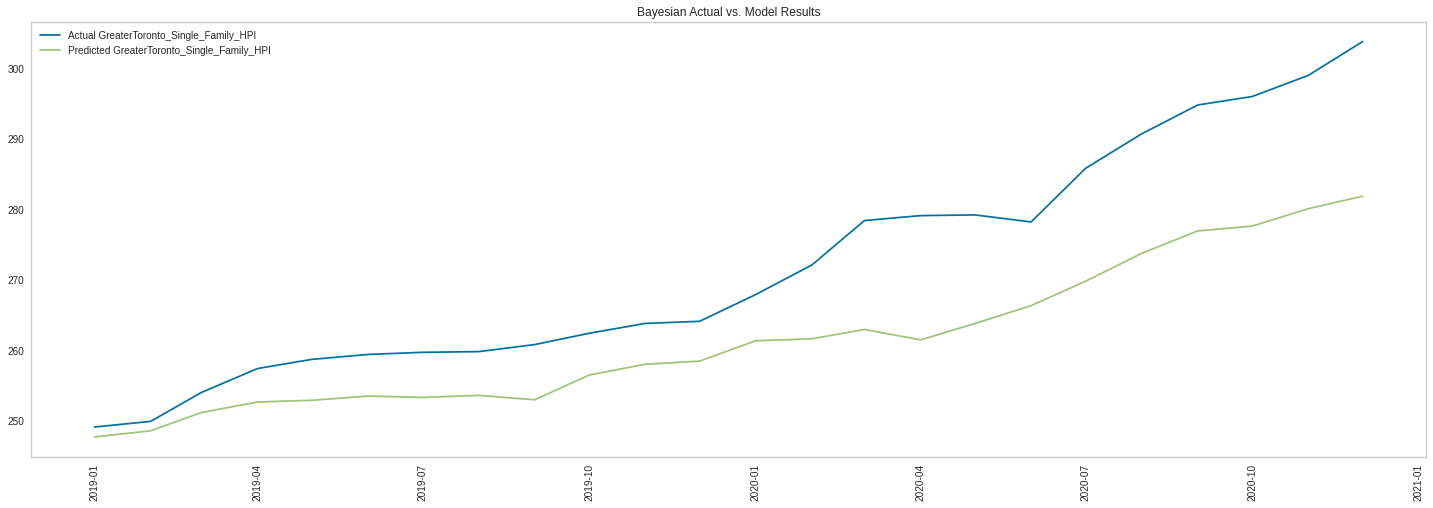

In [124]:
df_test_results = predict_test_values(model, X_test, y_test, X_test_date, 
                                      X_train, y_train)
plt.rcParams["figure.figsize"] = (25,8)
plot_test_results(df_test_results, model_num)

In [115]:
model.intercept_

-38135.82907315551

In [114]:
list(zip(X_train.columns,model.coef_))

[('1Yr_MetroOntario_CPI_All', 0.5834139573049666),
 ('1M_MetroOntario_CPI_all', 0.13860502386336684),
 ('1Yr_MetroOntario_CPI_Shelter', 0.08514075424471047),
 ('1M_MetroOntario_CPI_Shelter', 0.29167669481212627),
 ('Month', 1.4608647684973357),
 ('1Yr_GreaterVancounver_Single_Family_HPI', 0.04485276288848995),
 ('1M_GreaterVancounver_Single_Family_HPI', 0.34976460845655316),
 ('1Yr_Montreal_Single_Family_HPI', 0.15422342829541913),
 ('1M_Montreal_Single_Family_HPI', -0.019209541534596364),
 ('1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
  0.007582153344556041),
 ('1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
  1.9452588801665813e-05),
 ('1Yr_RetailSales_Toronto', 2.7124402397331257e-06),
 ('1M_RetailSales_Toronto', -1.572682135187953e-06),
 ('1M_Avg_Temperature', 0.054910209742520484),
 ('1Yr_Avg_Temp', -0.1937635389805091),
 ('1M_Snow_onGround', 0.02962281783069864),
 ('1Yr_Snow_onGround', 0.4340091952172236),
 ('1M_Toronto_ConstructionCompletionsUnits', 0.0001828